In [1]:
#importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, Binarizer  # Include Binarizer here
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [2]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              2059 non-null   int64 
 1   Candidate       2059 non-null   object
 2   Constituency ∇  2059 non-null   object
 3   Party           2059 non-null   object
 4   Criminal Case   2059 non-null   int64 
 5   Total Assets    2059 non-null   object
 6   Liabilities     2059 non-null   object
 7   state           2059 non-null   object
 8   Education       2059 non-null   object
dtypes: int64(2), object(7)
memory usage: 144.9+ KB


In [4]:
# Assuming train_df is your training dataframe and it has already been loaded

# Extract currency units from 'Liabilities' and identify unique units
currency_units = {value.split()[-1] for value in train_df['Liabilities'] if isinstance(value, str)}

# Print the unique currency units
print(currency_units)


{'Hund+', 'Lac+', '0', 'Crore+', 'Thou+'}


In [5]:
def currency_to_num(currency_series):
    if pd.api.types.is_numeric_dtype(currency_series):
        return currency_series
    return pd.to_numeric(currency_series.str.replace(r'[^\d.]', '', regex=True), errors='coerce')

# Preprocess the data
for df in [train_df, test_df]:
    df['Total Assets'] = currency_to_num(df['Total Assets'])
    df['Liabilities'] = currency_to_num(df['Liabilities'])
    df['Assets_to_Liabilities'] = df['Total Assets'] / np.where(df['Liabilities'] == 0, 0.01, df['Liabilities'])

In [6]:
train_df['Total Assets'].value_counts()

Total Assets
1      276
2      230
0      189
3      140
4      135
      ... 
191      1
47       1
135      1
187      1
312      1
Name: count, Length: 132, dtype: int64

In [7]:
train_df['Liabilities'].corr(train_df['Criminal Case'])

-0.009933692676710263

In [8]:
train_df['Liabilities'].corr(train_df['Total Assets'])

0.2827220093613153

In [9]:
train_df['Total Assets'].corr(train_df['Criminal Case'])

0.005012785208239491

In [10]:
train_df['Criminal Case'].value_counts()

Criminal Case
0     1135
1      368
2      165
3      102
4       68
5       53
6       36
7       32
8       17
9       16
10       9
12       7
11       7
13       5
18       5
16       4
22       4
25       3
14       3
38       2
29       2
52       2
19       2
30       1
43       1
24       1
49       1
17       1
87       1
23       1
15       1
26       1
27       1
73       1
34       1
Name: count, dtype: int64

In [11]:
train_df.head()

,ID,Candidate,Constituency ∇,Party,Criminal Case,Total Assets,Liabilities,state,Education,Assets_to_Liabilities
0,0,M.K. Mohan,ANNA NAGAR,DMK,4,211,2,TAMIL NADU,8th Pass,105.500000
1,1,Khatik Ramesh Prasad,KARERA (SC),BJP,0,1,0,MADHYA PRADESH,12th Pass,100.000000
2,2,Dr. Mantar Gowda,MADIKERI,INC,0,7,22,KARNATAKA,Post Graduate,0.318182
3,3,Kundan Kumar,BEGUSARAI,BJP,0,9,24,BIHAR,Post Graduate,0.375000
4,4,Swapan Majumder,BANGAON DAKSHIN (SC),BJP,2,2,61,WEST BENGAL,8th Pass,0.032787


In [12]:
train_df['Party'].value_counts()

Party
BJP                         862
INC                         365
AITC                        130
AAP                          94
YSRCP                        86
DMK                          73
BJD                          65
SP                           62
CPI(M)                       43
RJD                          42
IND                          38
NCP                          34
AIADMK                       34
JD(U)                        32
SHS                          29
NPP                          20
JMM                          14
NDPP                          9
TDP                           8
JD(S)                         7
Sikkim Krantikari Morcha      5
CPI                           4
Tipra Motha Party             3
Name: count, dtype: int64

In [13]:
# Encode the 'Education' column
label_encoder = LabelEncoder()
train_df['Education'] = label_encoder.fit_transform(train_df['Education'])


In [14]:
# Imputation and scaling
numeric_columns = ['Total Assets', 'Liabilities', 'Assets_to_Liabilities']
imputer = SimpleImputer(strategy='mean')
train_df[numeric_columns] = imputer.fit_transform(train_df[numeric_columns])

In [15]:
train_df = pd.get_dummies(train_df.drop(['ID', 'Candidate', 'Constituency ∇'], axis=1), drop_first=True)

In [16]:
# Prepare data for modeling
X = train_df.drop('Education', axis=1)
y = train_df['Education']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [17]:
model = BernoulliNB()
search_space = {
    'alpha': Real(0.0001, 10, prior='log-uniform'),
    'binarize': Real(0.0, 1.0)  # Optimize threshold for binarizing in the model itself
}

In [18]:
# Setup Bayesian optimization
opt = BayesSearchCV(model, search_space, n_iter=32, scoring='f1_weighted', cv=StratifiedKFold(5), n_jobs=-1, random_state=42)
opt.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Evaluate the optimized model
y_pred = opt.best_estimator_.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
print(f'Optimized Validation Accuracy: {accuracy}')
print("Optimized F1-Score:", f1)

In [ ]:
# Ensure test_df columns match training features
test_df[numeric_columns] = imputer.transform(test_df[numeric_columns])
test_df = pd.get_dummies(test_df.drop(['Candidate', 'Constituency ∇'], axis=1), drop_first=True)
test_df = test_df.reindex(columns=X_train.columns, fill_value=0)


In [ ]:
# Predict on test data using the optimized binarization threshold
test_predictions = opt.predict(test_df)

In [ ]:
# Create a DataFrame from test_predictions
submission_df = pd.DataFrame({
    'ID': test_df.index,  # If 'ID' column is in test_df, replace 'index' with 'ID'
    'Education': label_encoder.inverse_transform(test_predictions)
})

In [ ]:
# Save to CSV
submission_df.to_csv('submission.csv', index=False)
print("Submission saved!")


In [ ]:
print(train_df.columns)


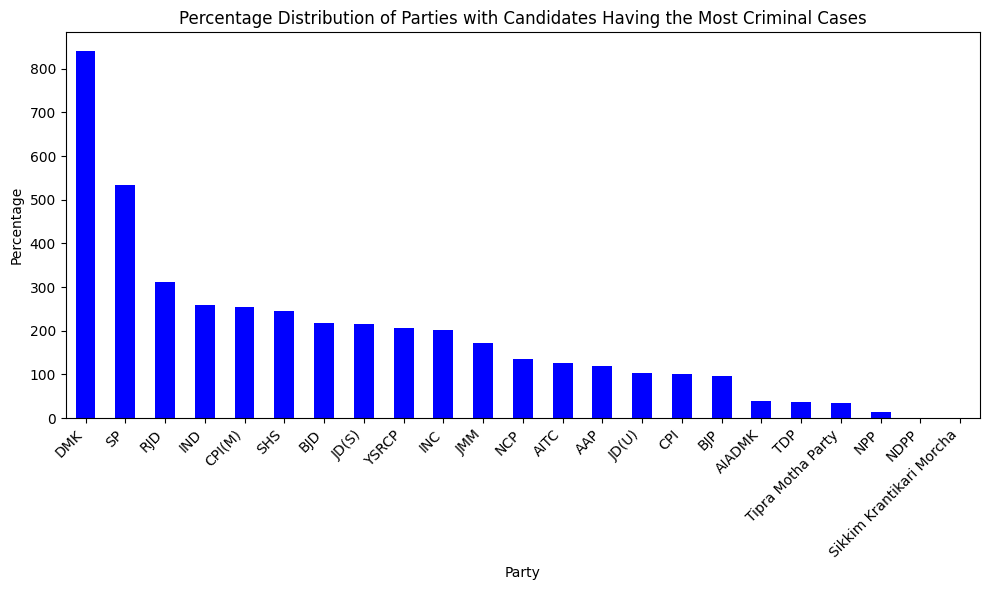

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_csv('train.csv')

# Calculate the percentage distribution of parties with candidates having the most criminal cases
criminal_cases_distribution = train_df.groupby('Party')['Criminal Case'].sum() / train_df.groupby('Party')['Criminal Case'].count() * 100
criminal_cases_distribution = criminal_cases_distribution.sort_values(ascending=False)

# Plot the percentage distribution of parties with candidates having the most criminal cases
plt.figure(figsize=(10, 6))
criminal_cases_distribution.plot(kind='bar', color='blue')
plt.title('Percentage Distribution of Parties with Candidates Having the Most Criminal Cases')
plt.xlabel('Party')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [ ]:
# Check unique values in the 'Total Assets' column
print(train_df['Total Assets'].unique())


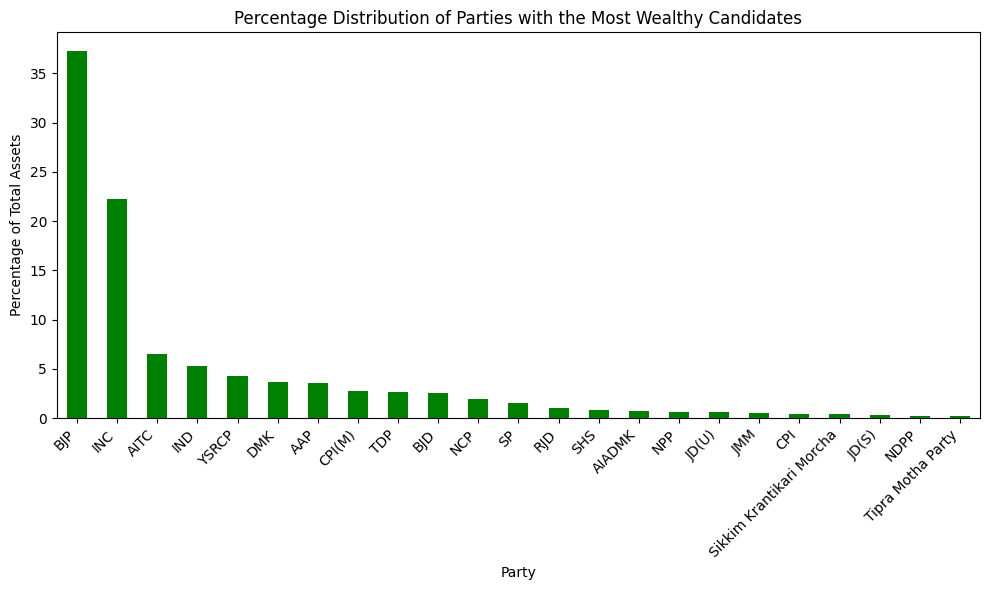

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
train_df = pd.read_csv('train.csv')

# Function to convert currency strings to numeric
def currency_to_num(currency_series):
    return pd.to_numeric(currency_series.str.replace(r'[^\d.]', '', regex=True), errors='coerce')

# Preprocess the data
train_df['Total Assets'] = currency_to_num(train_df['Total Assets'])

# Calculate the total assets held by each party
party_assets = train_df.groupby('Party')['Total Assets'].sum()

# Calculate the percentage distribution of parties with the most wealthy candidates
wealthy_candidates_distribution = party_assets / party_assets.sum() * 100
wealthy_candidates_distribution = wealthy_candidates_distribution.sort_values(ascending=False)

# Plot the percentage distribution of parties with the most wealthy candidates
plt.figure(figsize=(10, 6))
wealthy_candidates_distribution.plot(kind='bar', color='green')
plt.title('Percentage Distribution of Parties with the Most Wealthy Candidates')
plt.xlabel('Party')
plt.ylabel('Percentage of Total Assets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

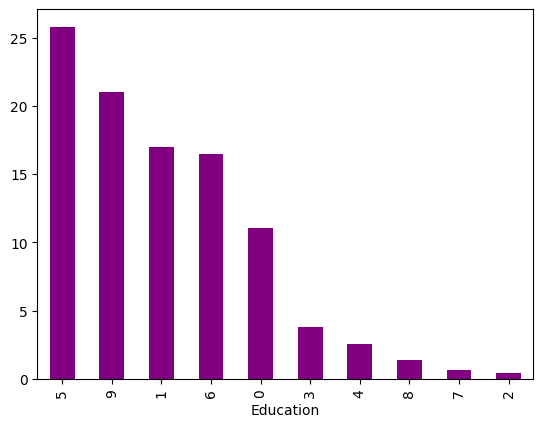

In [19]:
education_distribution = train_df['Education'].value_counts(normalize=True) * 100
education_distribution.plot(kind='bar', color='purple')
plt.title('Distribution of Education Levels among Candidates')
plt.ylabel('Percentage')
plt.show()


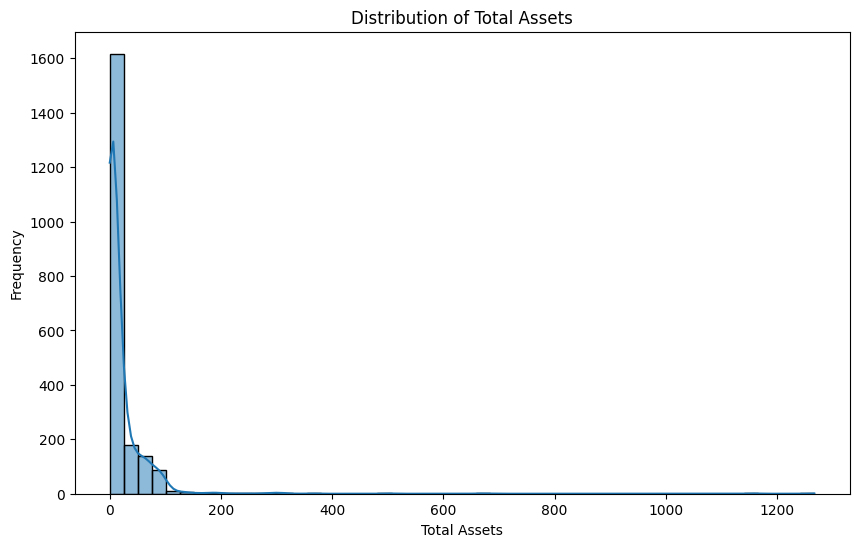

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example code for a histogram of 'Total Assets'
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Total Assets'], bins=50, kde=True)
plt.title('Distribution of Total Assets')
plt.xlabel('Total Assets')
plt.ylabel('Frequency')
plt.show()

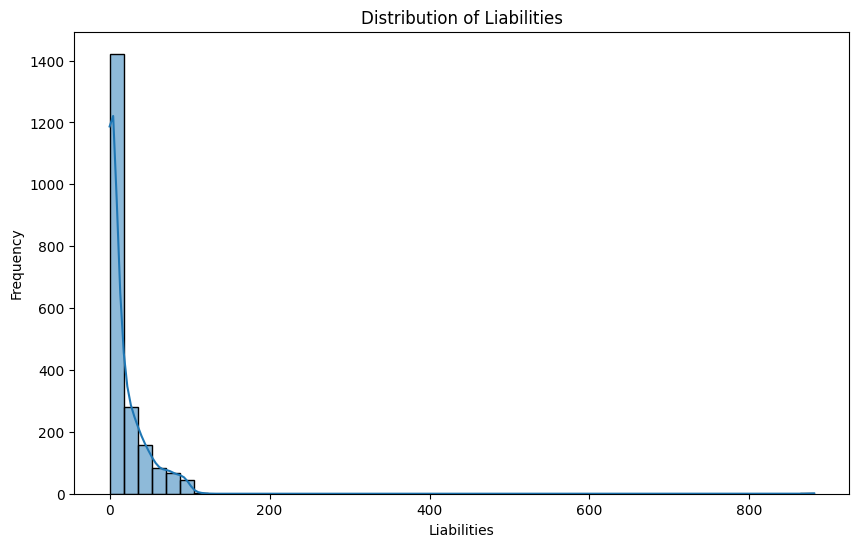

In [21]:
# Example code for a histogram of 'Liabilities'
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Liabilities'], bins=50, kde=True)
plt.title('Distribution of Liabilities')
plt.xlabel('Liabilities')
plt.ylabel('Frequency')
plt.show()


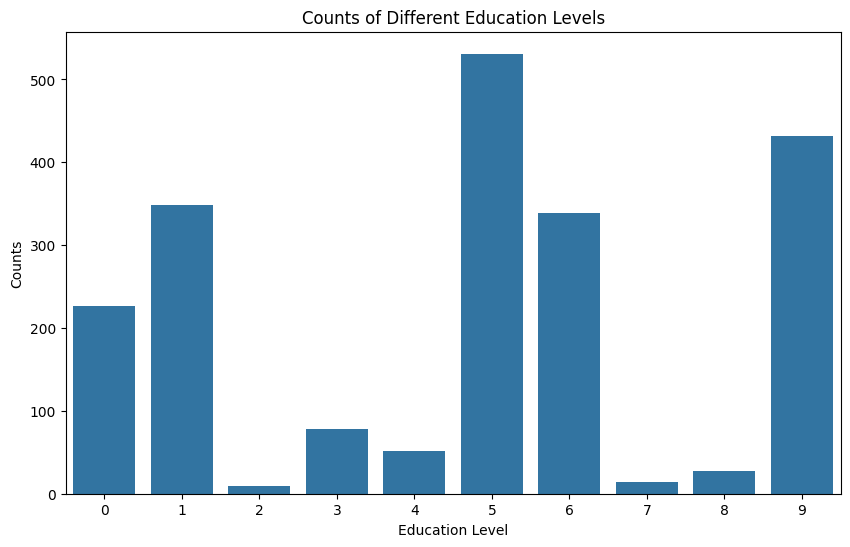

In [22]:
# Example code for a bar plot of 'Education' levels
education_counts = train_df['Education'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=education_counts.index, y=education_counts.values)
plt.title('Counts of Different Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Counts')
plt.show()

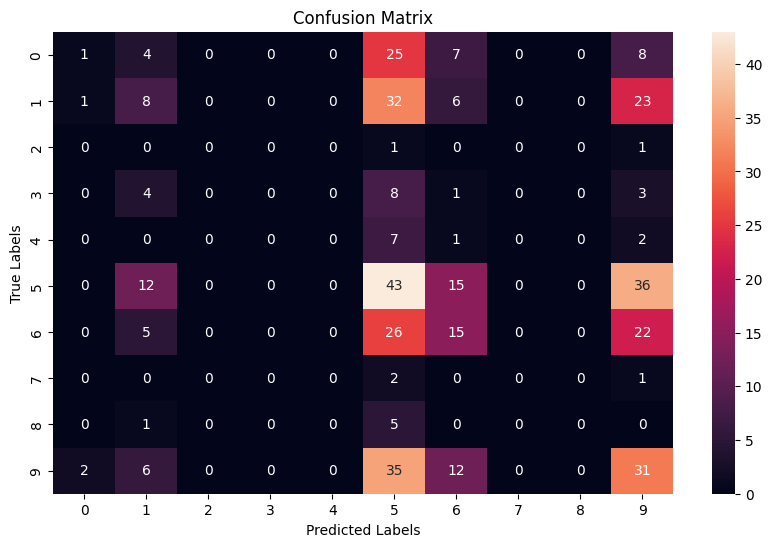

In [ ]:
# Example code for a confusion matrix of the model predictions
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()